In [1]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("../Mu-Helper/muhelper")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../Mu-Helper/muhelper/helper_visa.py'>

In [2]:
filepath = "../Keysight/data_waveform/"
filenames= ["waveform_scintillator_bar_SENSL_FAST.joblib"]

In [43]:
# plot(np.mean(np.array(data_save[1])[inds_keep],axis=0));
# plot(np.array(data_save[1])[inds_keep][6]);


In [7]:
i=0
data_save=joblib.load(filepath+f"{filenames[i]}")
time_series = data_save["metadata"]["time_series"]*1e9

pulses_raw = np.array(data_save[1])

# inds_keep,cut_passage_fraction = hp.cut_pulses(pulses_raw, cut_iterations = 1, cut_amp=[0.003,0.007], cut_triggerpoint = False)
trace_info = hp.get_pulses_info(pulses_raw, pre_trig=800, threshold_in_sigma=5, gaussian_filter_sigma=3)

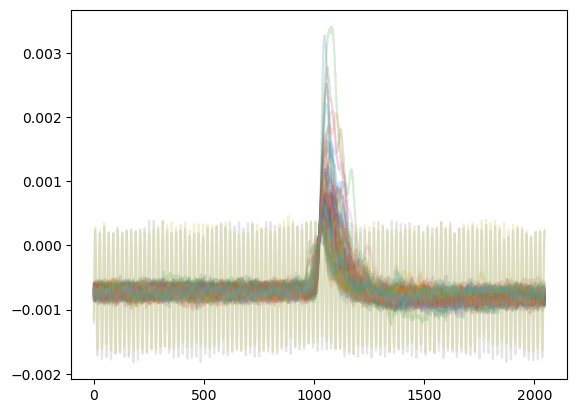

In [8]:
for i in range(100):
    plot(pulses_raw[i], alpha=0.2)

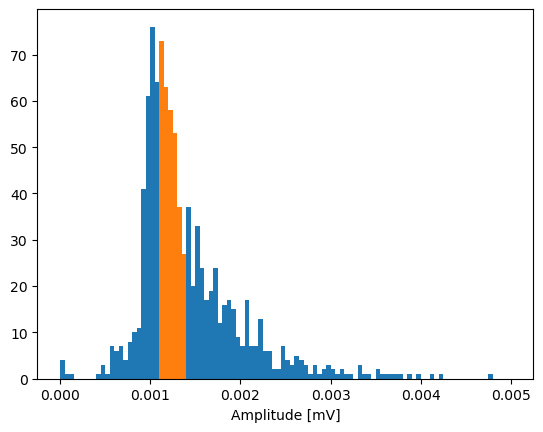

Text(0.5, 0, 'Time [ns]')

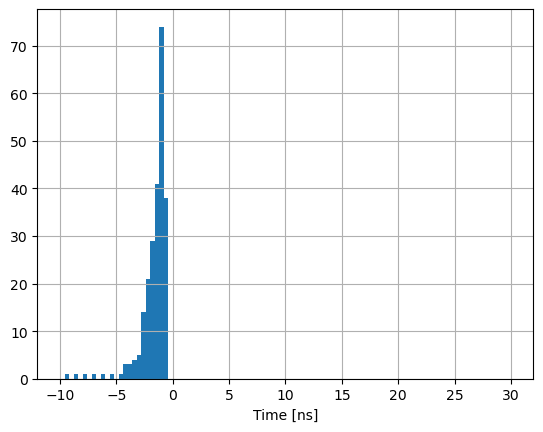

In [33]:
# Select >10 pe events
trace_amp = trace_info[:,-1]
mask_amp = (0.0011<trace_amp)&(trace_amp<0.0014)
hist(trace_amp,bins=100, range=(0,0.005));
hist(trace_amp[mask_amp],bins=100, range=(0,0.005));
xlabel("Amplitude [mV]")
show()

#------------------------------------------
# Find trigger time at 1.5 pe
trigger_threshold = -0.0005
trigger_time_ind = np.array([np.argmax(i>trigger_threshold) for  i in pulses_raw])
# trigger_time_ind = np.copy(trace_info[:,-2])
trigger_time = time_series[trigger_time_ind]
# trigger_time_selected_1pe = trigger_time[mask_amp&mask_pileup]
# passage_fraction = sum(mask_amp&mask_pileup)/len(mask_amp)
# print("passage_fraction",passage_fraction)


n,ibins,_ = hist(trigger_time[mask_amp],bins=100,range=(-10,30));
bincenters= 0.5*(ibins[1:]+ibins[:-1])

x=bincenters
y=n
# popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,10], maxfev=1000, makeplot=True)
# exp = lambda x, A,tau: A*np.exp(-x/tau)
# popt, pcov, info, f = hp.fit_curve(exp,x,y, p0=[np.max(y),10], fit_range=(3,30),maxfev=1000, makeplot=True)

# yscale("log")
# xlim(-5,45)
ylim(-0.0002,)
grid(which="both")
xlabel("Time [ns]")

[ 0.88206626 -0.21589691  2.58815086  2.58808437]


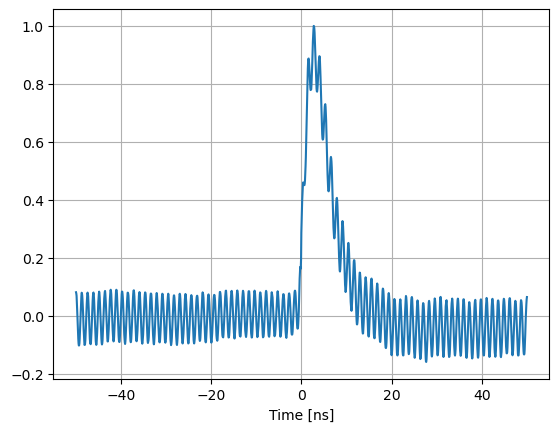

In [42]:
#-----------------------------------------------------------------------------------------
# Make average pulse
mask = mask_amp
pulse_avg = np.zeros_like(pulses_raw[0])
for i in np.flatnonzero(mask):
    time_offset = trigger_time_ind[i]-len(pulses_raw[0])//2
    pulse = np.roll(pulses_raw[i], -int(time_offset))
    pulse/=max(pulse)
    pulse_avg +=pulse
    # print(time_offset)
    # pulse_avg +=pulses_raw[i]
pulse_avg-=np.mean(pulse_avg[:int(len(pulse_avg)/2.2)])

mask_save = abs(time_series)<50
pulse_avg = pulse_avg[mask_save]
pulse_avg/=max(pulse_avg)
pulse_avg_time = time_series[mask_save]

# PLot and fit
plot(pulse_avg_time, pulse_avg)
x=pulse_avg_time
y=pulse_avg
# popt, pcov, info, f = hp.fit_curve(hp.Pulse2,x,y, p0=[0.5,5,20,np.max(y),np.max(y)/2,x[np.argmax(y)],np.max(y)], maxfev=1000, makeplot=True)
# popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,10], maxfev=1000, makeplot=True)

# yscale("log")
# xlim(-10,45)
# ylim(-0.0002,)
grid(which="both")
xlabel("Time [ns]")
print(popt)
show()


pulse_save = {"time_series_ns":pulse_avg_time,
              "averaged_pulse":pulse_avg}
# joblib.dump(pulse_save,"data/averaged_pulse_scintillator_SENSL.joblib")

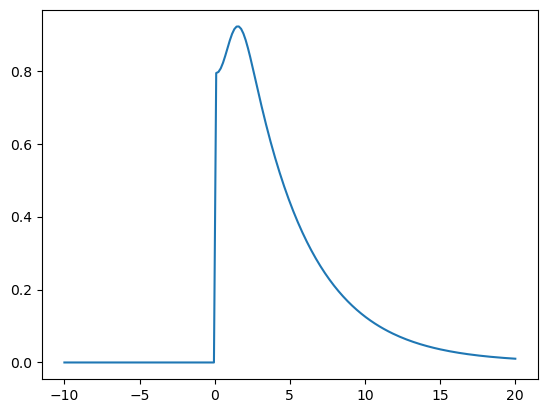

In [69]:
def ExpGauss(x, t0, sigma, tau, B, C):
    return C*(1+scipy.special.erf(x-t0-sigma**2/tau)/(np.sqrt(2)*sigma)) * np.exp(-(x-t0)/tau) * np.exp(sigma**2 / tau**2 / 2)* np.heaviside(x-t0, 0) +B
x=np.linspace(-10,20,200)
y=ExpGauss(x, -0, 2, 4, 0, 1)
plot(x,y)
# ylim(0,)

dict_keys(['time_series_ns', 'averaged_pulse'])
[ 0.88206626 -0.21589691  2.58815086  2.58808437]
[2.1392999  4.03504465]


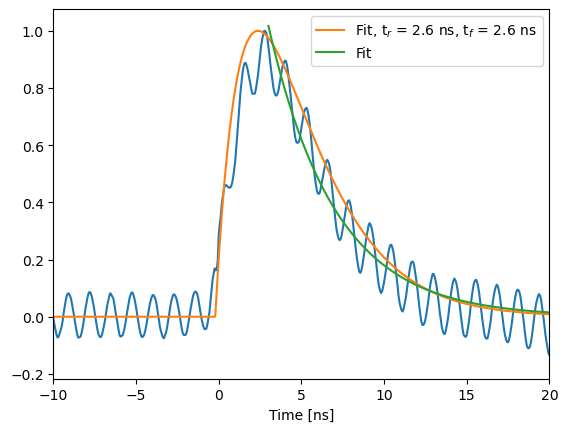

Scintillator parameter [A, x0, t1, t2] [2.1392999  4.03504465]


In [45]:
data1 = joblib.load("data/averaged_pulse_scintillator_SENSL.joblib")
print(data1.keys())
scint_time = data1["time_series_ns"]
scint_pulse = data1["averaged_pulse"]
scint_pulse/=max(scint_pulse)





# Fit the scintilator pulse 
plot(scint_time,scint_pulse)
x=scint_time
y=scint_pulse
# popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y),x[np.argmax(y)],2,3], fit_range=(-20,30), maxfev=1000, makeplot=False)
# fit_plotx = np.linspace(min(x),max(x),4000)
# fit_ploty = hp.Pulse(fit_plotx, *popt)
# fit_ploty/=max(fit_ploty)
# print(popt)
# plot(fit_plotx, fit_ploty, label=f"Fit, t$_r$ = {popt[2]:.1f} ns, t$_f$ = {popt[3]:.1f} ns")



exp = lambda x, A,tau: A*np.exp(-x/tau)
popt, pcov, info, f = hp.fit_curve(exp,x,y, p0=[np.max(y),10], fit_range=(3,20),maxfev=1000, makeplot=True)
print(popt)

xlim(-10,20)
legend()
xlabel("Time [ns]")
show()
print("Scintillator parameter [A, x0, t1, t2]", popt)
